# Introduction to Tensorboard using King's County Housing Prices
<br>


In [1697]:
#Import our libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from scipy import stats
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
%matplotlib inline

In [1698]:
#Load our King's County dataset in and see how are data is structured
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [1699]:
#We drop `id` and `date` as we are only interested   
df.drop(['id', 'date'], axis=1, inplace=True)
#Let's check and make sure we have no null or NAN values 
df.isnull().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

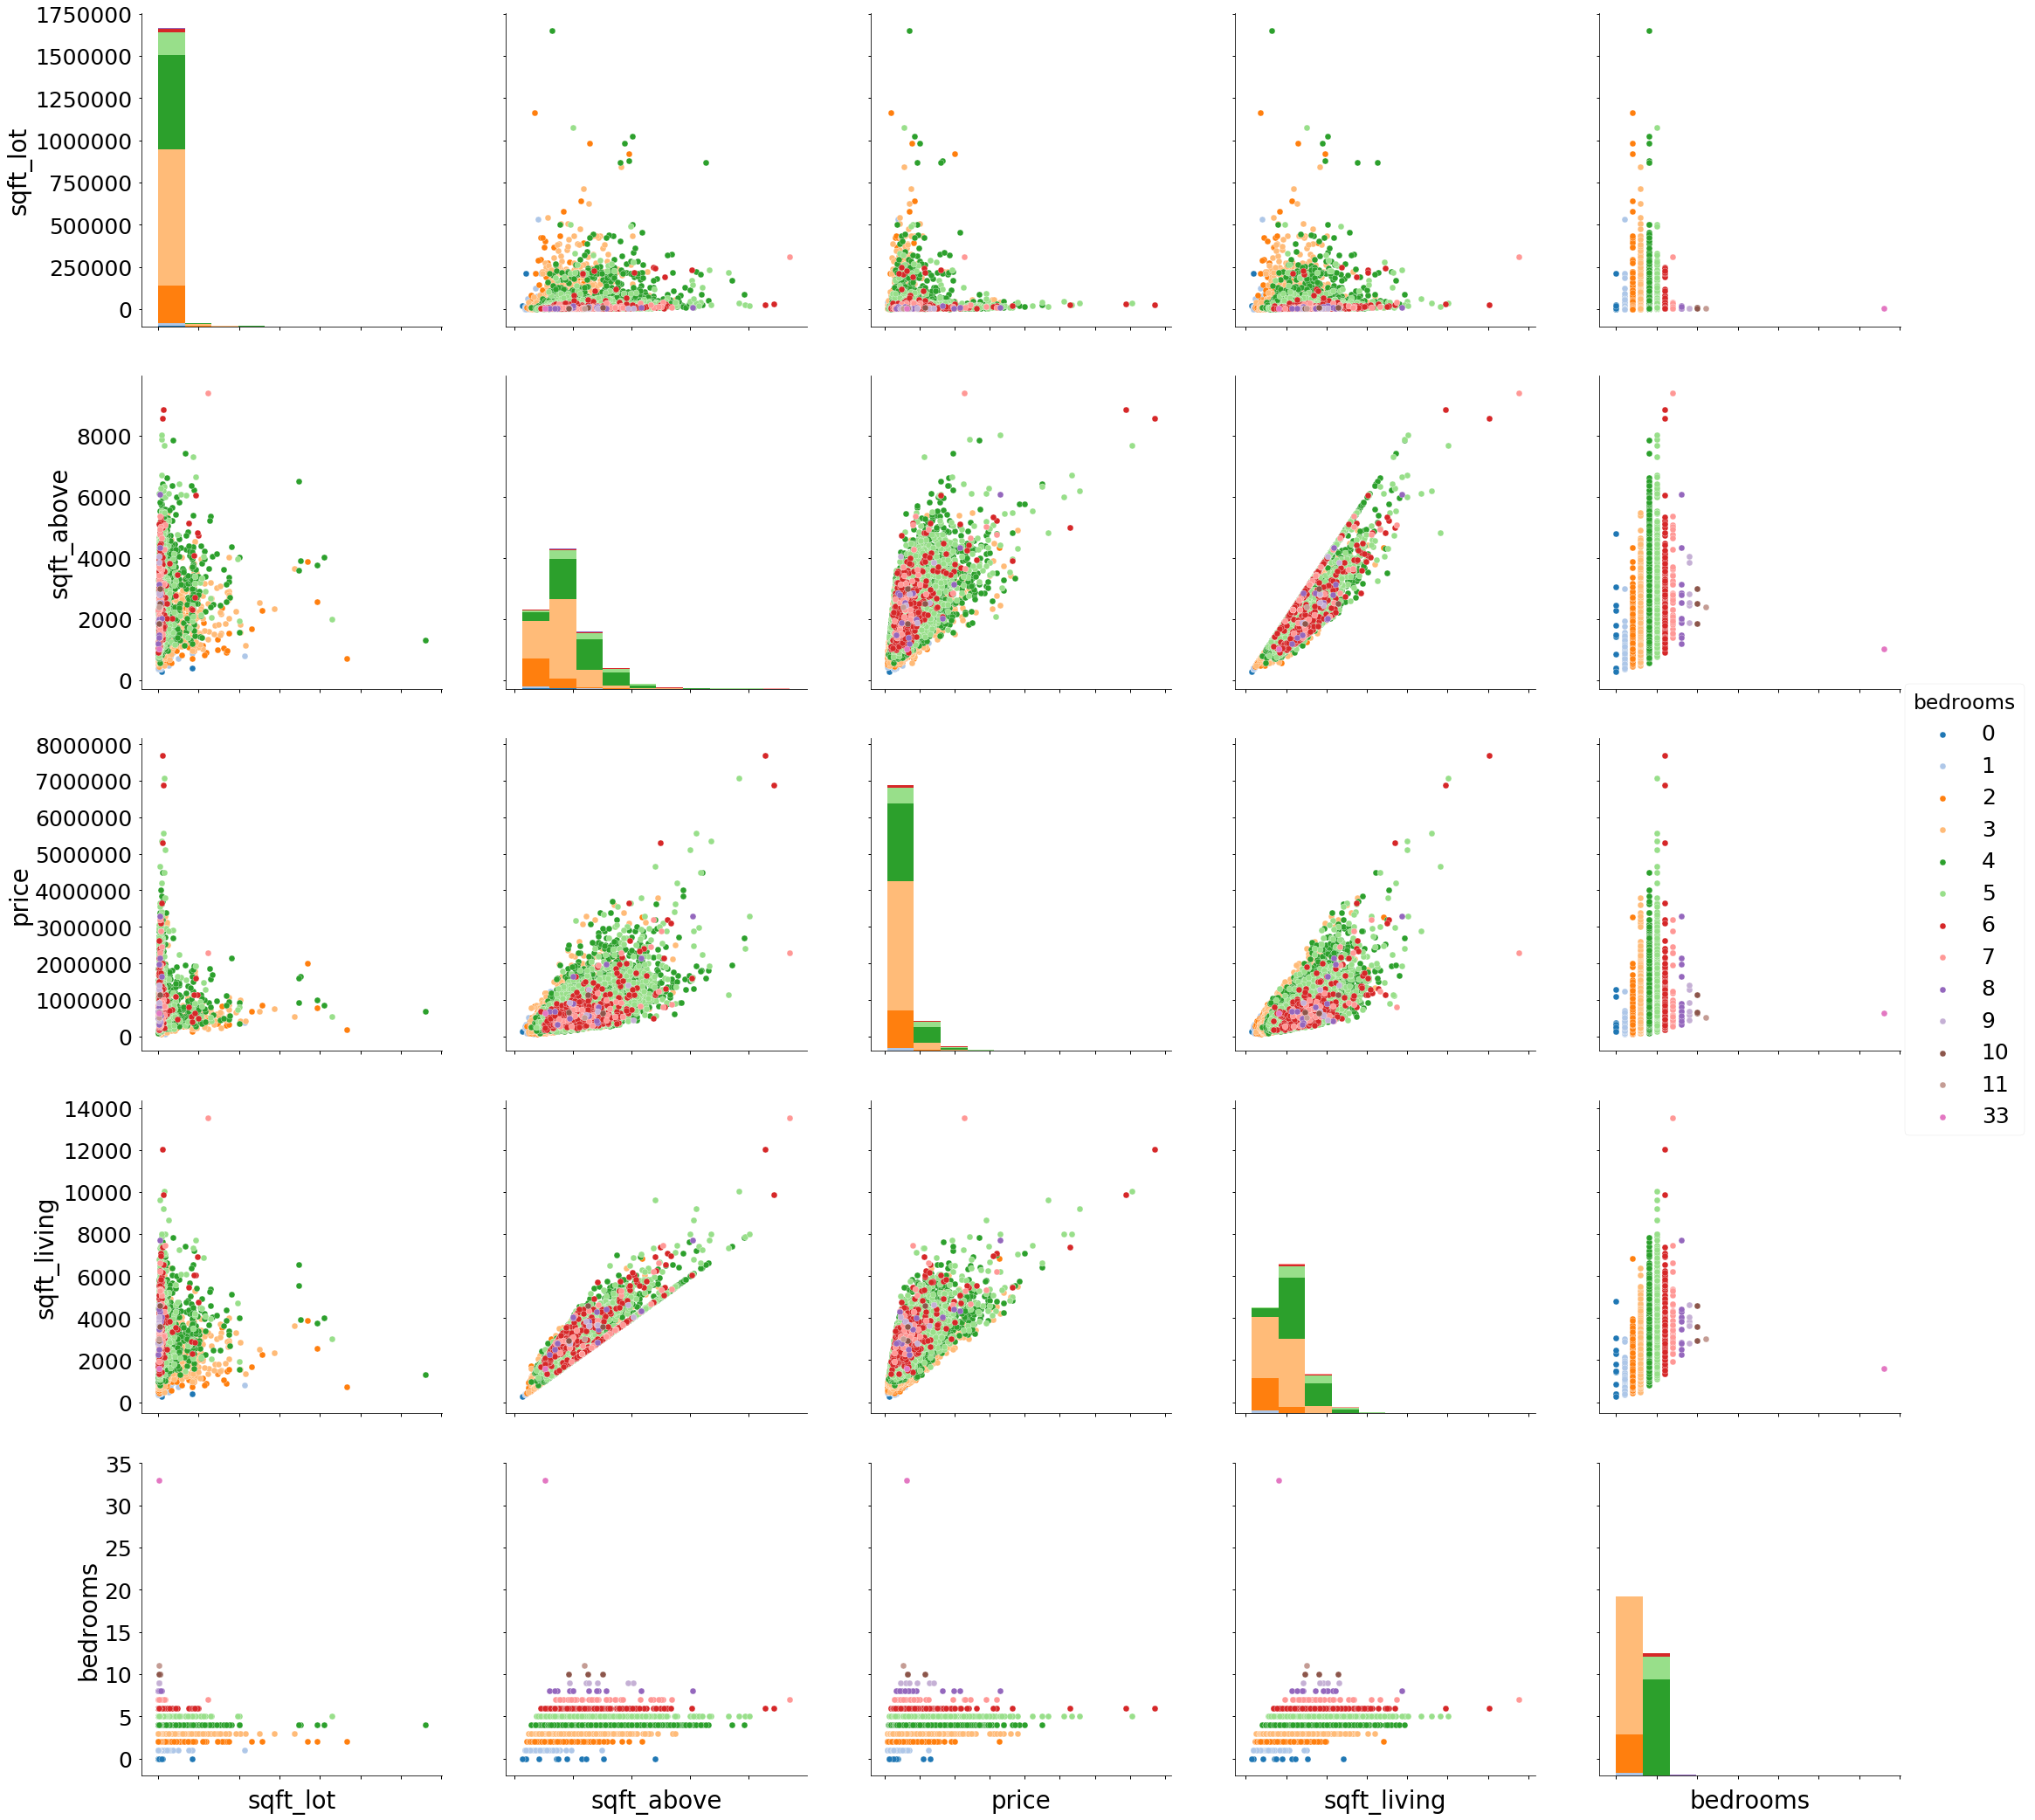

In [1700]:
#Let's examine a few relationships to see how our data is distributed
with sns.plotting_context("notebook",font_scale=2.5):
    g = sns.pairplot(df[['sqft_lot','sqft_above','price','sqft_living','bedrooms']], 
                 hue='bedrooms', palette='tab20',size=6)
g.set(xticklabels=[])

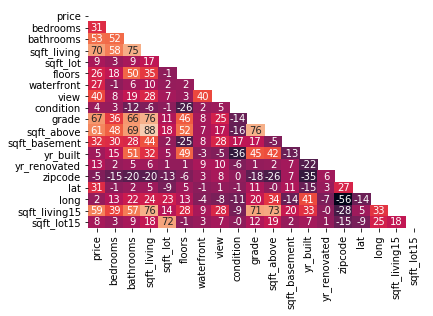

In [1701]:
# Generate a mask for the upper triangle
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#Let's use a heatmap to better visualize the correlations amongst the features
sns.heatmap(corr*100, mask = mask, annot = True ,fmt='.0f', cbar=False)

In [1702]:
#Now we begin the modeling process; first we split up our target variable from our input features
y = df.price.reshape(-1, 1)
X = df.drop('price', axis = 1)

/Users/kkoehncke/anaconda/envs/standard_3_6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [1703]:
#Split data into 80 / 20 training & test sets (no validation for simplicity)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [1704]:
#Apply feature scaling & normalization in case we apply regularization later
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

In [1705]:
#Obtain our batch of a given size
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  
    indices = np.random.randint(m, size=batch_size)  
    X_batch = X_train[indices] 
    y_batch = y_train[indices]
    return X_batch, y_batch

In [1706]:
# Construction Phase
n_epochs = 200
learning_rate = 0.01
batch_size = 128
n_hidden1 = 100
n_hidden2 = 50
n_outputs = 1
m, n = X_train.shape

n_batches = int(np.ceil(m / batch_size))
#Reset default graph 
tf.reset_default_graph()

In [1707]:
with tf.name_scope('input'):
    X = tf.placeholder(tf.float64, shape=(None, n), name="x_input") 
    #Target MSE
    y = tf.placeholder(tf.float64, shape=(None, n_outputs), name="y_input")  
    #Set dropout default to 0 so that during testing, we do not apply dropout
    dropout_prob = tf.placeholder_with_default(0.0, shape=(), name="dropout_prob")

In [1708]:
#We do not a name scope as the layers already provide enough encapsulation
#On our Tensorboard
hidden1 = tf.layers.dense(X, n_hidden1, name="hidden_layer_1",
                                  activation=tf.nn.tanh,
                                  use_bias=True)
dropout = tf.layers.dropout(hidden1, rate=dropout_prob, name="dropout_layer")
hidden2 = tf.layers.dense(dropout, n_hidden2, name="hidden_layer_2",
                                  activation=tf.nn.relu,
                                  use_bias=True)
output = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [1709]:
with tf.name_scope("loss"):
    MSE = tf.losses.mean_squared_error(labels = y,
                                     predictions = output)
    tf.summary.scalar('MSE', MSE)

In [1710]:
with tf.name_scope("train"):
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(MSE)

In [1711]:
#Create histograms of all trainable variables
variables = [v for v in tf.trainable_variables()]
for var in variables:
        tf.summary.histogram(var.name[:-2], var)

In [1712]:
from sklearn.metrics import r2_score
def calculate_R_squared(y, prediction):
    return (r2_score(y, prediction))

In [1713]:
init = tf.global_variables_initializer()
#merge all summaries into a single "operation" which we can execute in a session 
summary_op = tf.summary.merge_all()

#Get current time and create directory where we will perform logging
current_time = time.strftime("%Y_%m_%d-%H:%M:%S")
logs_path = "/tmp/kings_county/" + current_time

with tf.Session() as sess:
    # variables need to be initialized before we can use them
    init.run()
    # create log writer object
    writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    print_trainables()
    # perform training cycles
    for epoch in range(n_epochs):
       if epoch % 5 == 0:
           print("Epoch: ", epoch, 'Train MSE: ', MSE.eval({X: X_train, y: y_train}))
       for batch_index in range(n_batches):
           X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
           _, summary = sess.run([train_op, summary_op], 
                                            feed_dict={X: X_batch, y: y_batch,
                                                      dropout_prob: 0.5})
           #Write 
           writer.add_summary(summary, epoch * n_batches + batch_index)
    #Evaluate our trained model; set dropout to 1 as we are done training
    print("Overall Train MSE: ", MSE.eval({X: X_train, y: y_train}))
    print("Overall Test MSE: ", MSE.eval({X: X_test, y: y_test}))
    print("Predictions: ", output.eval({X: X_test}))
    print("R^2: ", calculate_R_squared(y_test, output.eval({X: X_test})))
    writer.close()

Variable:  hidden_layer_1/kernel:0
Shape:  (18, 100)
Variable:  hidden_layer_1/bias:0
Shape:  (100,)
Variable:  hidden_layer_2/kernel:0
Shape:  (100, 50)
Variable:  hidden_layer_2/bias:0
Shape:  (50,)
Variable:  outputs/kernel:0
Shape:  (50, 1)
Variable:  outputs/bias:0
Shape:  (1,)
Epoch:  0 Train MSE:  426707780000.0
Epoch:  5 Train MSE:  242287700000.0
Epoch:  10 Train MSE:  113546985000.0
Epoch:  15 Train MSE:  95277270000.0
Epoch:  20 Train MSE:  76045420000.0
Epoch:  25 Train MSE:  62564463000.0
Epoch:  30 Train MSE:  53982630000.0
Epoch:  35 Train MSE:  47933997000.0
Epoch:  40 Train MSE:  43624325000.0
Epoch:  45 Train MSE:  41043120000.0
Epoch:  50 Train MSE:  38058836000.0
Epoch:  55 Train MSE:  36236538000.0
Epoch:  60 Train MSE:  34383450000.0
Epoch:  65 Train MSE:  33047017000.0
Epoch:  70 Train MSE:  30904019000.0
Epoch:  75 Train MSE:  28908669000.0
Epoch:  80 Train MSE:  27503264000.0
Epoch:  85 Train MSE:  26701576000.0
Epoch:  90 Train MSE:  25712128000.0
Epoch:  95 T

In [1574]:
#TODO - Implement in Keras and discuss how to use Tensorboard in Keras

In [1634]:
y_test

array([[485000.],
       [358000.],
       [716500.],
       ...,
       [660000.],
       [300000.],
       [465000.]])